In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
device = torch.device('cuda:0')
dtype = torch.float32
torch.backends.cudnn.benchmark = True

In [3]:
def read_all_image_folders(directories):
    images_075, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 1))        
                images_075.append(scale_image(image, 0.25))
    return images_075, images_300

In [4]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [5]:
learning_rate = 0.001
batch_size = 16
epochs = 26

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 45, kernel_size = 11, stride = 1, padding = 5),
            nn.ReLU(),
            nn.ConvTranspose2d(45, 30, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(30, 15, kernel_size = 9, stride = 2, padding = 4, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 3, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [7]:
model = generator().cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [9]:
def train(directories, epochs, batch_size):
    
    l_start = time.time()
    
    data_075, data_300 = read_all_image_folders(directories)
    x = torch.tensor(data_075, device = device, dtype = dtype)
    y = torch.tensor(data_300, device = device, dtype = dtype)
    del data_075, data_300
    
    print(f'Data loaded (m): {round((time.time() - l_start) / 60, 2)}')
    print('----------')
    
    loss_hist = []
    psnr_hist = []
    
    start = time.time()

    for t in range(epochs):
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
            batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
            outputs = model.forward(batch_x)

            loss = criterion(outputs, batch_y)
            psnr = 10 * math.log10(1 / F.mse_loss(outputs, batch_y))
            
            del batch_x, batch_y
            torch.cuda.empty_cache()
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % 1 == 0:
            loss_hist.append(loss.item())
            psnr_hist.append(psnr)
            print(t, f"PSNR: {psnr}, BCE: {loss.item()}, Time (m): {round((time.time() - start) / 60, 2)}")
            if psnr > 30:
                model.cpu()
                torch.save(model, f'../data/models/x4_{psnr}.pt')
                model.cuda()
            
    print('----------')
    print(f'Train Time (m): {round((time.time() - start) / 60, 2)}')
    
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1) 
    plt.title('PSNR')
    plt.plot(psnr_hist)
    plt.subplot(1,2,2)
    plt.title('BCE')
    plt.plot(loss_hist)
    plt.show()
    
    print(f'Memory allocated before clear: {torch.cuda.memory_cached()/1000**2} MB')
    del x, y
    torch.cuda.empty_cache()
    print(f'Memory allocated after clear: {torch.cuda.memory_cached()/1000**2} MB')
    
    return psnr

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data loaded (m): 6.23
----------
0 PSNR: 20.862136089026283, BCE: 0.5402600765228271, Time (m): 1.3
1 PSNR: 22.942583233814133, BCE: 0.5329889059066772, Time (m): 2.58
2 PSNR: 23.712119925736665, BCE: 0.5306763648986816, Time (m): 3.86
3 PSNR: 23.930394000340023, BCE: 0.5302982926368713, Time (m): 5.19
4 PSNR: 24.59266698252668, BCE: 0.5280048251152039, Time (m): 6.53
5 PSNR: 24.43513038651851, BCE: 0.5290946364402771, Time (m): 7.88
6 PSNR: 24.721863929982568, BCE: 0.5278393030166626, Time (m): 9.22
7 PSNR: 25.796730543696587, BCE: 0.5257352590560913, Time (m): 10.54
8 PSNR: 25.63511611092364, BCE: 0.5262378454208374, Time (m): 11.88
9 PSNR: 25.803916512262997, BCE: 0.5257734060287476, Time (m): 13.17
10 PSNR: 25.35485270071987, BCE: 0.5270481705665588, Time (m): 14.44
11 PSNR: 26.083997467797218, BCE: 0.5251882672309875, Time (m): 15.76
12 PSNR: 26.24847697690452, BCE: 0.5249428153038025, Time (m): 17.09
13 PSNR: 26.02045875997772, BCE: 0.5254248380661011, Time (m): 18.43
14 PSNR: 26

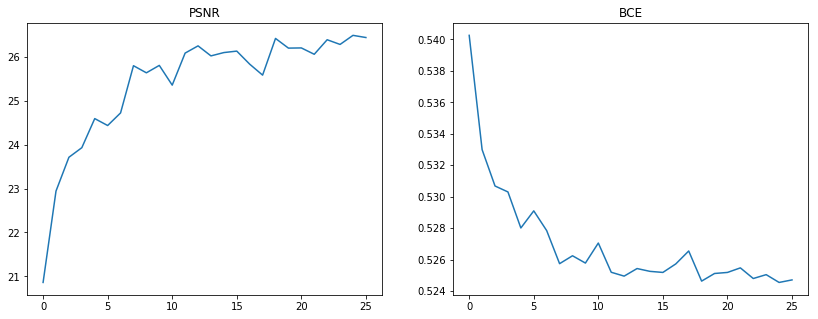

Memory allocated before clear: 6369.050624 MB
Memory allocated after clear: 22.544384 MB


In [10]:
psnr = train([0, 1, 2], epochs, batch_size)

Data loaded (m): 6.04
----------
0 PSNR: 26.844264933265393, BCE: 0.5303579568862915, Time (m): 1.21
1 PSNR: 26.412114703184155, BCE: 0.5309470295906067, Time (m): 2.41
2 PSNR: 26.77137225644622, BCE: 0.5305318236351013, Time (m): 3.62
3 PSNR: 26.982596661006557, BCE: 0.530176043510437, Time (m): 4.84
4 PSNR: 26.955122442379135, BCE: 0.5302299857139587, Time (m): 6.08
5 PSNR: 26.987538105676737, BCE: 0.5301346778869629, Time (m): 7.32
6 PSNR: 27.037131106733085, BCE: 0.5301089882850647, Time (m): 8.56
7 PSNR: 26.992536715885265, BCE: 0.5301386117935181, Time (m): 9.81
8 PSNR: 27.00929709049388, BCE: 0.5301454663276672, Time (m): 11.09
9 PSNR: 26.96952232509893, BCE: 0.530252993106842, Time (m): 12.38
10 PSNR: 26.911312645609907, BCE: 0.5303536057472229, Time (m): 13.64
11 PSNR: 27.01077165931369, BCE: 0.5301223993301392, Time (m): 14.9
12 PSNR: 27.113029386785552, BCE: 0.5300050973892212, Time (m): 16.13
13 PSNR: 27.087288143214746, BCE: 0.5300952196121216, Time (m): 17.37
14 PSNR: 27.

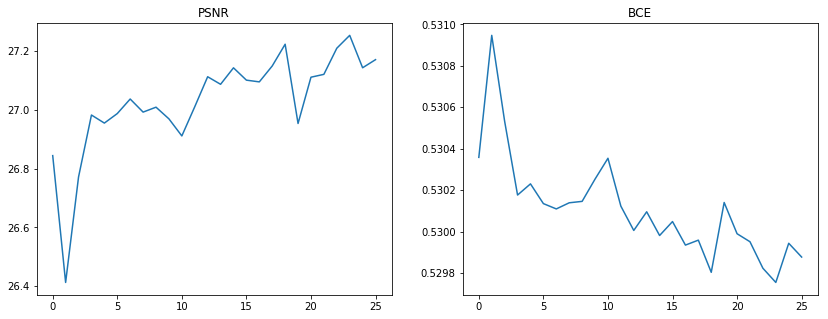

Memory allocated before clear: 6188.957696 MB
Memory allocated after clear: 22.544384 MB


In [11]:
psnr = train([3, 4, 5, 6], epochs, batch_size)

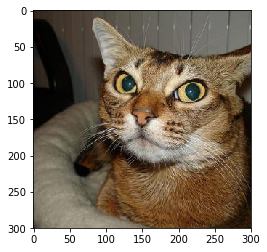

In [12]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

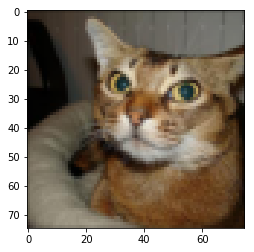

In [13]:
image_down = rescale(image=image, scale=0.25, multichannel=True, anti_aliasing=True)
plt.imshow(image_down)
plt.show()

In [14]:
image_up = model.forward(torch.tensor(image_down.reshape(1, 75, 75, 3), dtype = dtype, device = device).transpose(1, 3))

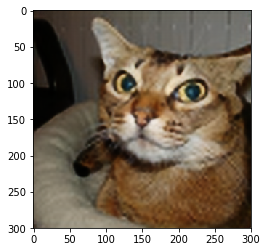

In [15]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(300, 300, 3))
plt.show()

In [16]:
torch.save(model.cpu(), f'../data/models/x4_F_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
